In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Extract and Clean Data

In [3]:
# Parse ss data
def parse_ss(file_path):
    # Open and parse the log file
    with open(file_path, "r") as file:
        lines = file.readlines()
    
    # Extract relevant fields
    data = []
    for line in lines:
        line = line.strip()  # Remove leading/trailing whitespace and tabs
        match = re.search(r"cwnd:(\d+)\s+ssthresh:(\d+).*lastsnd:(\d+)", line)
        if match:
            cwnd = int(match.group(1))
            ssthresh = int(match.group(2))
            time = int(match.group(3)) / 1000  # Convert milliseconds to seconds
            data.append((time, cwnd, ssthresh))
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Time (s)", "CWND", "SSTHRESH"])
    return df

In [4]:
df_ss_cubic_nodelay = parse_ss("../data/bulk_traffic/cubic_ss.txt")
df_ss_cubic_nodelay

,Time (s),CWND,SSTHRESH
0,0.002,1534,1403
1,0.001,1594,1403
2,0.007,1178,1127
3,0.001,934,854
4,0.006,1023,854
...,...,...,...
76,0.002,1017,796
77,0.001,1042,796
78,0.007,749,746
79,0.006,843,746


In [6]:
df_ss_cubic = parse_ss("../data_past/cwnd_ssthresh_cubic.txt")
df_ss_cubic

,Time (s),CWND,SSTHRESH
0,0.003,10,10
1,1.013,10,10
2,2.022,10,10
3,3.031,10,10
4,4.047,10,10
...,...,...,...
214,3.958,10,10
215,4.974,10,10
216,5.988,10,10
217,0.007,10,10


In [7]:
def plot_ss(df):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Filter for meaningful data (adjust thresholds based on your data)
    df = df[(df["CWND"] > 10) & (df["SSTHRESH"] > 10)]
    
    # Round Time to 1 decimal place
    df["Time (s)"] = df["Time (s)"].round(1)

    # Group by Time and calculate mean
    df = df.groupby("Time (s)").mean().reset_index()

    # Smooth the data using rolling averages
    df["CWND_Smoothed"] = df["CWND"].rolling(window=5, min_periods=1).mean()
    df["SSTHRESH_Smoothed"] = df["SSTHRESH"].rolling(window=5, min_periods=1).mean()

    print(df)

    # Plot CWND and SSTHRESH
    plt.figure(figsize=(10, 6))
    plt.plot(df["Time (s)"], df["CWND_Smoothed"], label="CWND (Smoothed)", linewidth=2)
    plt.plot(df["Time (s)"], df["SSTHRESH_Smoothed"], label="SSTHRESH (Smoothed)", linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Packets")
    plt.title("Congestion Window and Slow Start Threshold Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


   Time (s)         CWND    SSTHRESH  CWND_Smoothed  SSTHRESH_Smoothed
0       0.0  1550.409639  1301.13253    1550.409639         1301.13253


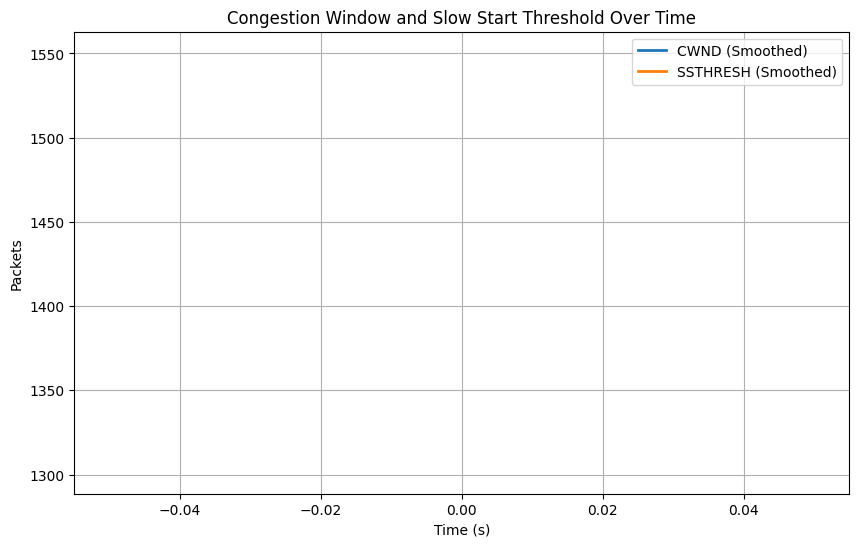

In [8]:
plot_ss(df_ss_cubic)

## iperf3 file

In [9]:
# Open and parse iperf3 output
def parse_iperf(file_path):
    # Initialize lists to store parsed data
    intervals, transfers, bitrates, retransmissions, cwnds = [], [], [], [], []
    
    # Regex pattern to match data rows
    pattern = re.compile(r'\[\s*\d+\]\s+([\d\.]+-[\d\.]+)\s+sec\s+([\d\.]+)\s+(MBytes|GBytes)\s+([\d\.]+)\s+(Mbits/sec|Gbits/sec)\s+(\d+)\s+([\d\.]+)\s+(KBytes|MBytes)')
    
    # Open and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                interval = match.group(1)
                transfer = float(match.group(2)) * (1024 if match.group(3) == "GBytes" else 1)
                bitrate = float(match.group(4)) * (1000 if match.group(5) == "Gbits/sec" else 1)
                retrans = int(match.group(6))
                cwnd = float(match.group(7)) * (1024 if match.group(8) == "MBytes" else 1)
    
                # Append parsed data to lists
                intervals.append(interval)
                transfers.append(transfer)
                bitrates.append(bitrate)
                retransmissions.append(retrans)
                cwnds.append(cwnd)
    
    # Create a DataFrame from the parsed data
    data = {
        "Interval": intervals,
        "Transfer (MB)": transfers,
        "Bitrate (Mbps)": bitrates,
        "Retransmissions": retransmissions,
        "CWND (KB)": cwnds
    }
    df = pd.DataFrame(data)
    return df

## Plot

In [10]:
def plot_iperf3_data(df):
    # Extracting the time intervals for x-axis
    time_intervals = df["Interval"].str.split("-", expand=True)[1].astype(float)

    # Creating a plot for Bitrate
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(time_intervals, df["Bitrate (Mbps)"], label="Bitrate (Mbps)", color='blue', marker='o')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Bitrate (Mbps)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Creating a secondary y-axis for CWND
    ax2 = ax1.twinx()
    ax2.plot(time_intervals, df["CWND (KB)"], label="CWND (KB)", color='orange', marker='x', linestyle='--')
    ax2.set_ylabel("CWND (KB)", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Adding title and grid
    plt.title("Bitrate and Congestion Window over Time")
    fig.tight_layout()  # Adjust layout to prevent overlap

    # Show the plot
    plt.show()

# Call the function
plot_iperf3_data(df_cubic_iperf_nodelay)

NameError: name 'df_cubic_iperf_nodelay' is not defined

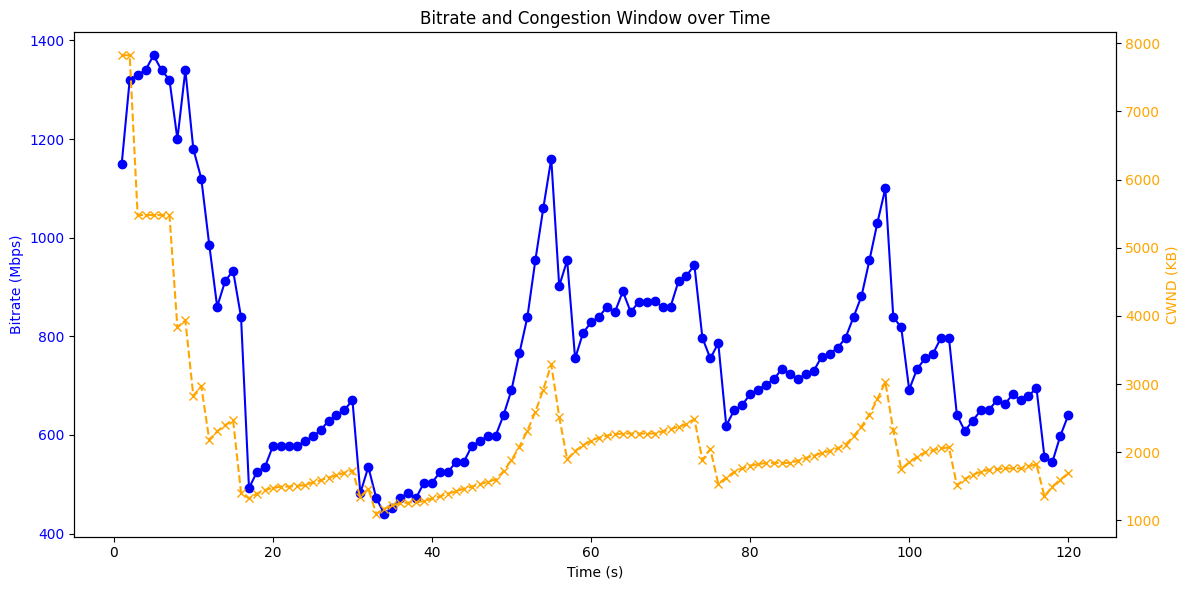

In [12]:
df_cubic_iperf = parse_iperf("../data_past/iperf3_cubic.txt")
plot_iperf3_data(df_cubic_iperf)

# Parse SS logs

In [13]:
# Parse CWND and SSTHRESH logs
def parse_ss_logs(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Extract time using a reliable reference (adjust as needed: `lastsnd`, `lastrcv`, `lastack`)
            time_match = re.search(r'lastrcv:(\d+)', line)  # Change to `lastrcv` for better consistency
            cwnd_match = re.search(r'cwnd:(\d+)', line)
            ssthresh_match = re.search(r'ssthresh:(\d+)', line)

            if time_match and cwnd_match:  # Require at least time and cwnd
                # Convert time to seconds
                time = float(time_match.group(1)) / 1000
                cwnd = int(cwnd_match.group(1))
                ssthresh = int(ssthresh_match.group(1)) if ssthresh_match else None
                data.append((time, cwnd, ssthresh))
            else:
                print(f"No match for line: {line.strip()}")  # Debugging message for unmatched lines

    # Convert the parsed data into a DataFrame
    df = pd.DataFrame(data, columns=["Time (s)", "CWND", "SSTHRESH"])

    # Define thresholds for "large" values as those above the 99th percentile
    cwnd_threshold = df["CWND"].quantile(0.99)
    ssthresh_threshold = df["SSTHRESH"].quantile(0.99)
    
    # Filtering: Remove rows where CWND and SSTHRESH exceed their respective 99th percentiles
    df = df[(df["CWND"] < cwnd_threshold) & (df["SSTHRESH"] < ssthresh_threshold)]


    return df


df_cubic_ss = parse_ss_logs("../data/bulk_traffic/cubic_ss.txt")
df_cubic_ss

,Time (s),CWND,SSTHRESH
4,2.276,1454,1403
6,3.301,1534,1403
8,4.323,1594,1403
10,5.339,1178,1127
12,6.359,878,854
...,...,...,...
226,115.170,1017,796
228,116.206,1042,796
230,117.232,749,746
232,118.248,843,746


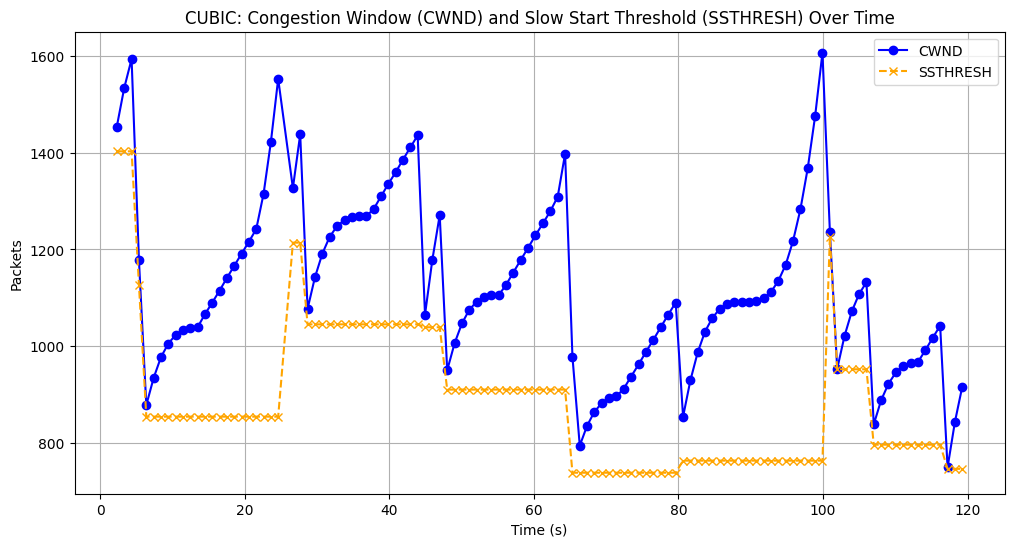

In [14]:
def plot_ss_data(df):
    # Plot CWND and SSTHRESH over time
    plt.figure(figsize=(12, 6))
    
    # Plot CWND
    plt.plot(df["Time (s)"], df["CWND"], label="CWND", color="blue", marker="o")
    
    # Plot SSTHRESH
    plt.plot(df["Time (s)"], df["SSTHRESH"], label="SSTHRESH", color="orange", linestyle="--", marker="x")
    
    # Labels, title, and legend
    plt.xlabel("Time (s)")
    plt.ylabel("Packets")
    plt.title("CUBIC: Congestion Window (CWND) and Slow Start Threshold (SSTHRESH) Over Time")
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

# Call the function with the filtered DataFrame
plot_ss_data(df_cubic_ss)

Experiment on BBR

In [15]:
df_bbr_ss = parse_ss_logs("../data/bulk_traffic/bbr_ss.txt")
df_bbr_ss

,Time (s),CWND,SSTHRESH
3,1.466,2036,1890
5,2.480,5730,1890
7,3.491,6174,1890
9,4.502,6052,1890
11,5.513,6136,1890
...,...,...,...
227,115.692,5852,1890
229,116.715,935,1890
231,117.734,6160,1890
233,118.753,1816,1890


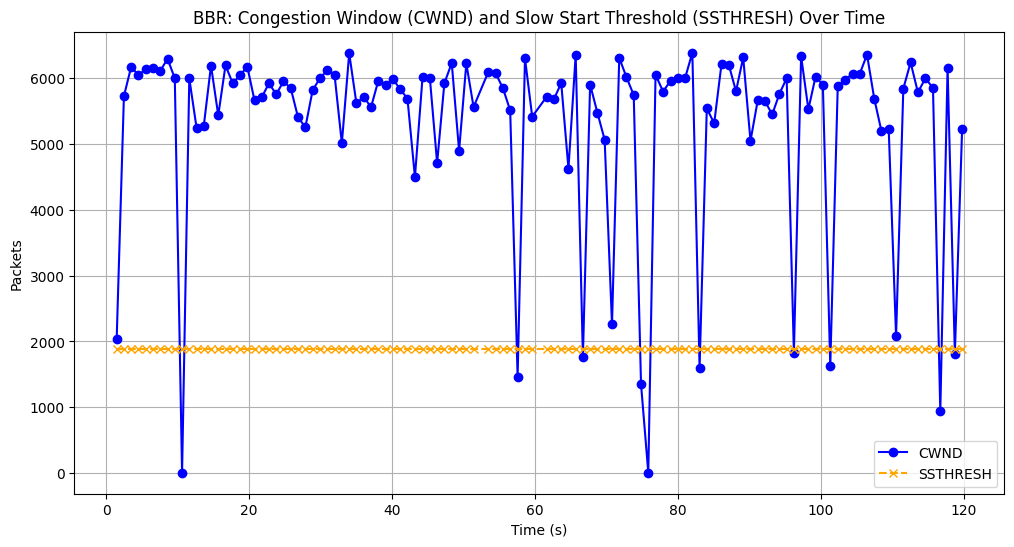

In [16]:
def plot_ss_data_bbr(df):
    # Plot CWND and SSTHRESH over time
    plt.figure(figsize=(12, 6))
    
    # Plot CWND
    plt.plot(df["Time (s)"], df["CWND"], label="CWND", color="blue", marker="o")
    
    # Plot SSTHRESH
    plt.plot(df["Time (s)"], df["SSTHRESH"], label="SSTHRESH", color="orange", linestyle="--", marker="x")
    
    # Labels, title, and legend
    plt.xlabel("Time (s)")
    plt.ylabel("Packets")
    plt.title("BBR: Congestion Window (CWND) and Slow Start Threshold (SSTHRESH) Over Time")
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

# Call the function with the filtered DataFrame
plot_ss_data_bbr(df_bbr_ss)

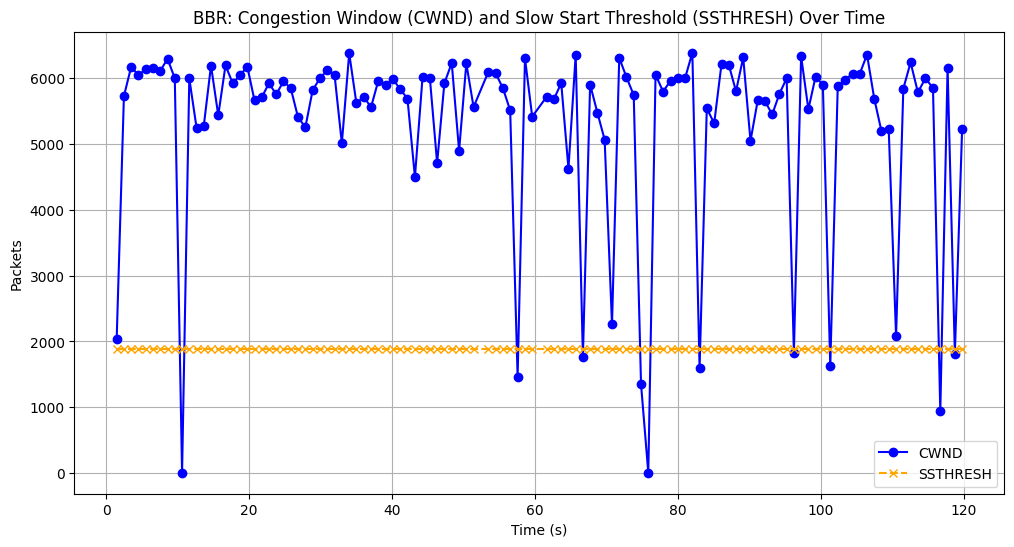

In [17]:
plot_ss_data_bbr(df_bbr_ss)

## Throughput

In [18]:
def parse_iperf3_throughput(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Match interval, transfer, and bitrate
            match = re.search(r"(\d+\.\d+-\d+\.\d+)\s+sec\s+[\d.]+\s+[MG]Bytes\s+([\d.]+)\s+([MG]bits/sec)", line)
            if match:
                interval = match.group(1)  # e.g., "0.00-1.00"
                bitrate = float(match.group(2))  # Extract bitrate
                unit = match.group(3)  # Extract the unit (e.g., "Mbits/sec" or "Gbits/sec")

                # Convert Gbits/sec to Mbits/sec if necessary
                if "Gbits/sec" in unit:
                    bitrate *= 1000
                
                data.append((interval, bitrate))

    return pd.DataFrame(data, columns=["Interval", "Throughput (Mbps)"])

# Example Usage
df_cubic = parse_iperf3_throughput("../data/bulk_traffic/iperf3_cubic.txt")
df_bbr = parse_iperf3_throughput("../data/bulk_traffic/iperf3_bbr.txt")
# print(df_cubic.head(10))
print(df_bbr.head(10))

     Interval  Throughput (Mbps)
0   0.00-1.00             1050.0
1   1.00-2.00             1260.0
2   2.00-3.00             1150.0
3   3.00-4.00             1080.0
4   4.00-5.00             1160.0
5   5.00-6.00             1080.0
6   6.00-7.00             1110.0
7   7.00-8.00             1170.0
8   8.00-9.00             1140.0
9  9.00-10.00             1060.0


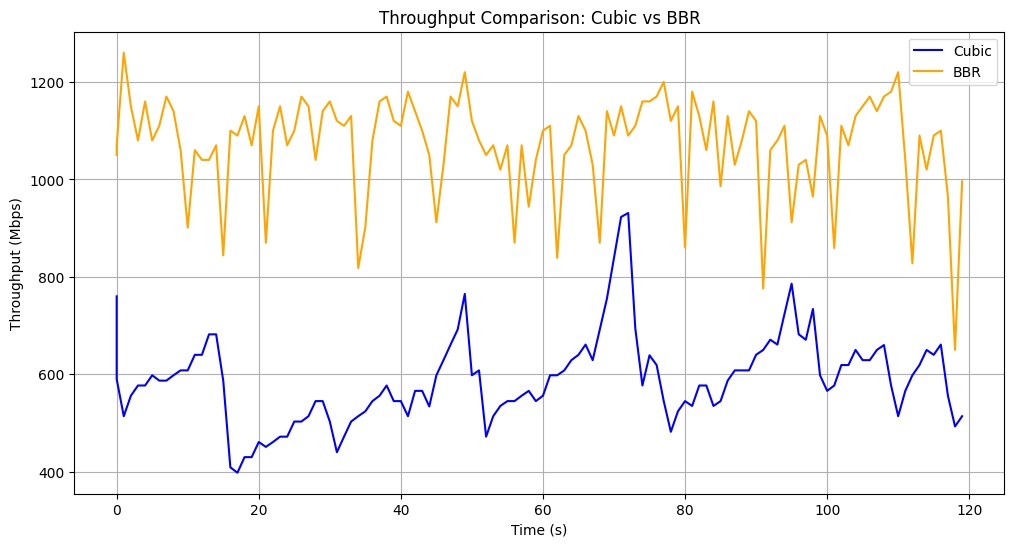

In [19]:
# Example corrected plotting function
def plot_throughput_comparison(df_cubic, df_bbr):
    # Convert interval to start time
    df_cubic['Time (s)'] = df_cubic['Interval'].str.split('-').str[0].astype(float)
    df_bbr['Time (s)'] = df_bbr['Interval'].str.split('-').str[0].astype(float)

    # Sort the data by time
    df_cubic = df_cubic.sort_values(by='Time (s)')
    df_bbr = df_bbr.sort_values(by='Time (s)')

    # Plot the throughput
    plt.figure(figsize=(12, 6))
    plt.plot(df_cubic['Time (s)'], df_cubic['Throughput (Mbps)'], label='Cubic', color='blue')
    plt.plot(df_bbr['Time (s)'], df_bbr['Throughput (Mbps)'], label='BBR', color='orange')
    
    # Add labels, title, and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Throughput (Mbps)')
    plt.title('Throughput Comparison: Cubic vs BBR')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Call the function with your DataFrames
plot_throughput_comparison(df_cubic, df_bbr)

## FCT

In [20]:
import json



In [21]:
def parse_fct(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract FCT details
    summary = data["end"]["sum_sent"]
    fct = summary["seconds"]  # Flow Completion Time in seconds
    transfer = summary["bytes"] / (1024 * 1024)  # Convert bytes to MB
    throughput = summary["bits_per_second"] / (10**6)  # Convert to Mbps
    
    return {"Flow Size (MB)": transfer, "FCT (s)": fct, "Throughput (Mbps)": throughput}

# Example usage for CUBIC and BBR
fct_cubic = parse_fct("../data/bulk_traffic/fct/fct_cubic_1G.json")
fct_bbr = parse_fct("../data/bulk_traffic/fct/fct_bbr_1G.json")
print(fct_cubic)
print(fct_bbr)

{'Flow Size (MB)': 1024.6691589355469, 'FCT (s)': 14.308615, 'Throughput (Mbps)': 600.725360490865}
{'Flow Size (MB)': 1024.148551940918, 'FCT (s)': 7.231892, 'Throughput (Mbps)': 1187.957554675872}


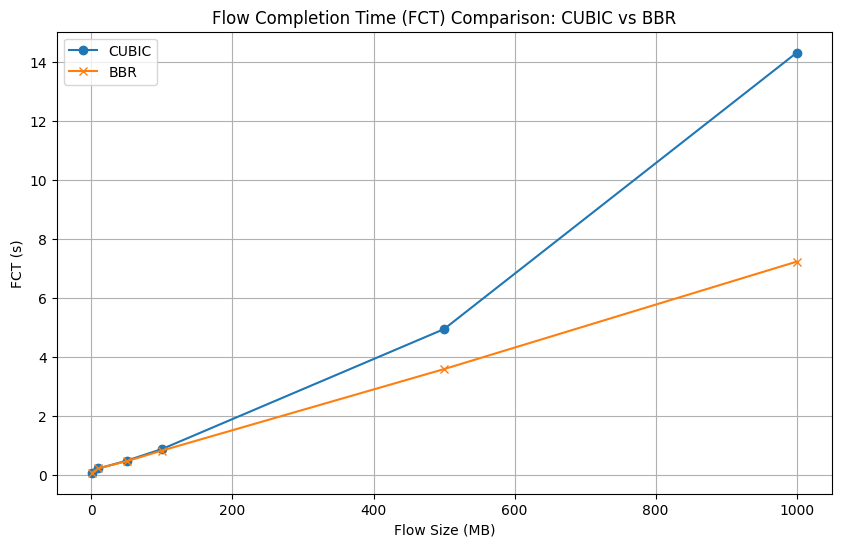

In [22]:
# Example Data (replace with actual parsed results)
flow_sizes = [1, 10, 50, 100, 500, 1000]  # in MB
fct_cubic = [0.082566, 0.22618, 0.490992, 0.884057, 4.947555, 14.308615]  # Replace with actual FCT values
fct_bbr = [0.090093, 0.229865, 0.472029, 0.832184, 3.592712, 7.231892]  # Replace with actual FCT values

plt.figure(figsize=(10, 6))
plt.plot(flow_sizes, fct_cubic, marker='o', label='CUBIC')
plt.plot(flow_sizes, fct_bbr, marker='x', label='BBR')
plt.xlabel("Flow Size (MB)")
plt.ylabel("FCT (s)")
plt.title("Flow Completion Time (FCT) Comparison: CUBIC vs BBR")
plt.legend()
plt.grid()
plt.show()

## RTT

In [23]:
def parse_rtt(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Extract RTT value before the "/"
            match = re.search(r"rtt:(\d+\.\d+)/", line)
            if match:
                rtt = float(match.group(1))  # RTT in ms
                data.append(rtt)

    # Convert to DataFrame
    return pd.DataFrame(data, columns=["RTT (ms)"])

# Example Usage
df_bbr_rtt = parse_rtt("../data/bulk_traffic/bbr_ss.txt")
df_cubic_rtt = parse_rtt("../data/bulk_traffic/cubic_ss.txt")
print(df_bbr_rtt.head(10))
print(df_cubic_rtt.head(10))

   RTT (ms)
0    24.902
1    22.381
2    24.902
3    25.459
4    24.902
5    20.361
6    24.902
7    20.464
8    24.902
9    20.595
   RTT (ms)
0    21.944
1    24.859
2    22.626
3    24.859
4    20.568
5    24.859
6    21.131
7    24.859
8    20.330
9    24.859


In [24]:
# Compute basic statistics
print(f"BBR Mean RTT: {df_bbr_rtt['RTT (ms)'].mean():.2f} ms")
print(f"CUBIC Mean RTT: {df_cubic_rtt['RTT (ms)'].mean():.2f} ms")

BBR Mean RTT: 23.55 ms
CUBIC Mean RTT: 22.97 ms


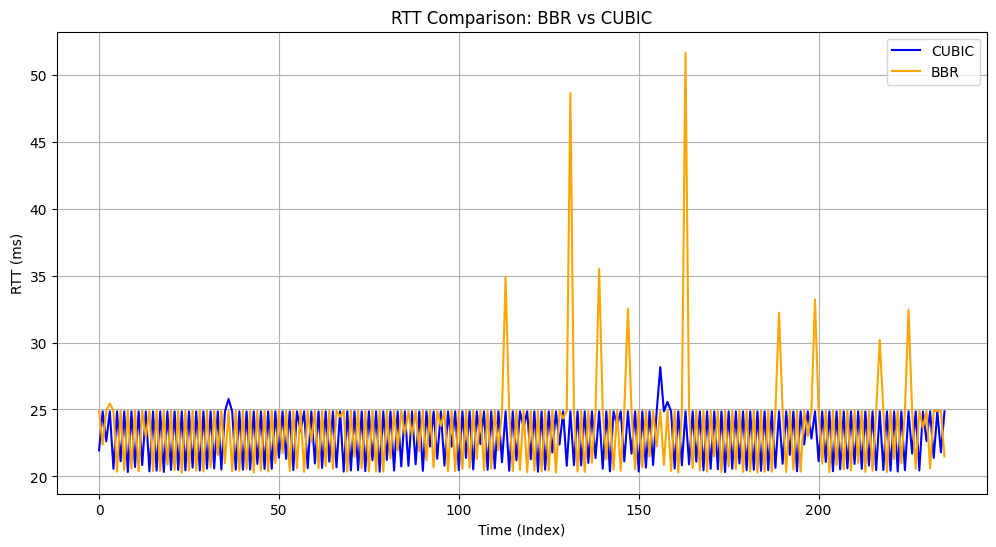

In [25]:
# Plot RTT for BBR and CUBIC
plt.figure(figsize=(12, 6))
plt.plot(df_cubic_rtt.index, df_cubic_rtt["RTT (ms)"], label="CUBIC", color='blue')
plt.plot(df_bbr_rtt.index, df_bbr_rtt["RTT (ms)"], label="BBR", color='orange')
plt.title("RTT Comparison: BBR vs CUBIC")
plt.xlabel("Time (Index)")
plt.ylabel("RTT (ms)")
plt.legend()
plt.grid()
plt.show()

# Loss 0.005%

In [95]:
df_loss5_cubic_iperf = parse_iperf("../data/bulk_traffic/loss5_iperf3_cubic.txt")
df_loss5_cubic_iperf

,Interval,Transfer (MB),Bitrate (Mbps),Retransmissions,CWND (KB)
0,0.00-1.00,103.0,864.0,1176,2775.04
1,1.00-2.00,108.0,902.0,284,2058.24
2,2.00-3.00,97.5,818.0,0,2170.88
3,3.00-4.00,98.8,828.0,71,1587.20
4,4.00-5.01,75.0,623.0,0,1689.60
...,...,...,...,...,...
115,115.00-116.00,58.8,493.0,0,1310.72
116,116.00-117.00,58.8,493.0,0,1310.72
117,117.00-118.00,60.0,503.0,0,1310.72
118,118.00-119.00,61.2,514.0,0,1331.20


In [91]:
df_loss5_bbr_iperf = parse_iperf("../data/bulk_traffic/loss5_iperf3_bbr.txt")
df_loss5_bbr_iperf

,Interval,Transfer (MB),Bitrate (Mbps),Retransmissions,CWND (KB)
0,0.00-1.00,124.0,1040.0,49,2764.80
1,1.00-2.00,129.0,1080.0,2062,1884.16
2,2.00-3.00,134.0,1120.0,298,8437.76
3,3.00-4.00,126.0,1060.0,760,5263.36
4,4.00-5.00,128.0,1070.0,763,8826.88
...,...,...,...,...,...
115,115.00-116.00,121.0,1020.0,1284,8693.76
116,116.00-117.00,121.0,1020.0,583,8642.56
117,117.00-118.00,135.0,1130.0,724,8632.32
118,118.00-119.00,129.0,1080.0,306,8540.16


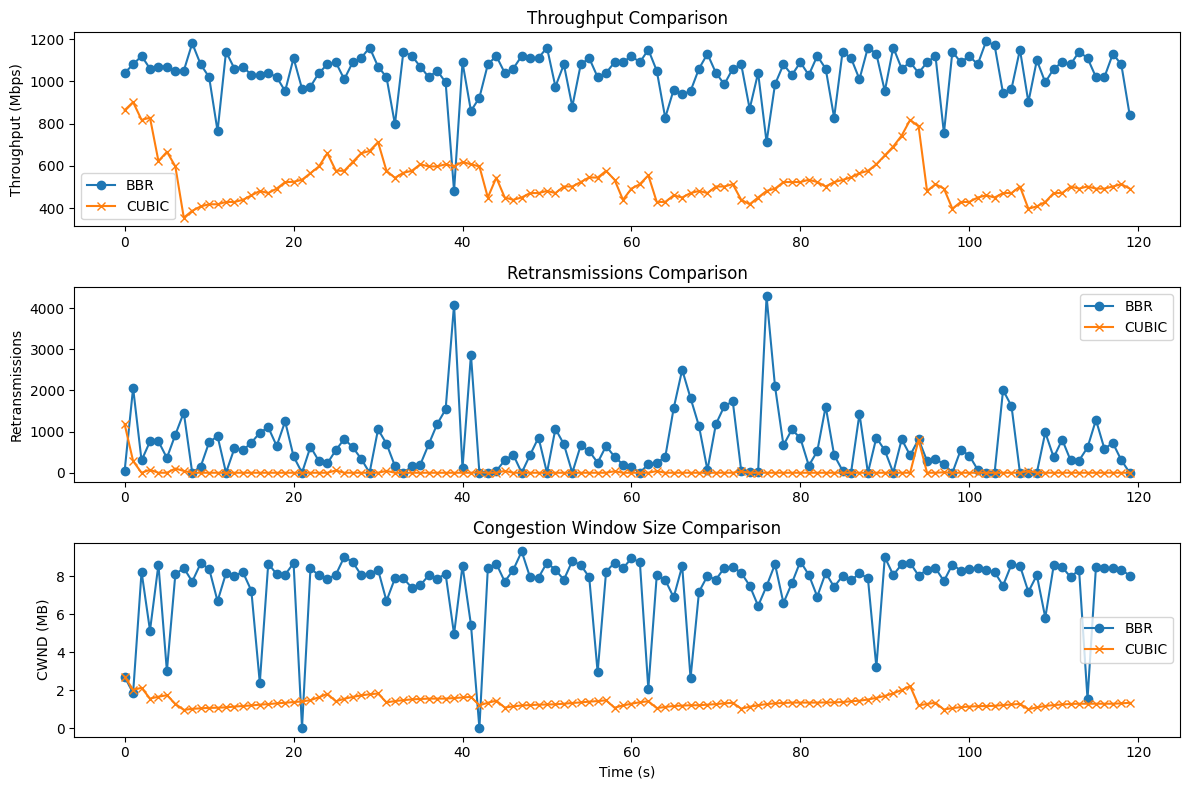

In [94]:
# Convert CWND from KB to MB for better readability
df_loss5_bbr_iperf["CWND (MB)"] = df_loss5_bbr_iperf["CWND (KB)"] / 1024
df_loss5_cubic_iperf["CWND (MB)"] = df_loss5_cubic_iperf["CWND (KB)"] / 1024

# Extract time interval start for plotting
df_loss5_bbr_iperf["Interval Start (s)"] = df_loss5_bbr_iperf["Interval"].str.split("-").str[0].astype(float)
df_loss5_cubic_iperf["Interval Start (s)"] = df_loss5_cubic_iperf["Interval"].str.split("-").str[0].astype(float)

# Plotting
plt.figure(figsize=(12, 8))

# Bitrate Plot
plt.subplot(3, 1, 1)
plt.plot(df_loss5_bbr_iperf["Interval Start (s)"], df_loss5_bbr_iperf["Bitrate (Mbps)"], label="BBR", marker='o')
plt.plot(df_loss5_cubic_iperf["Interval Start (s)"], df_loss5_cubic_iperf["Bitrate (Mbps)"], label="CUBIC", marker='x')
plt.ylabel("Throughput (Mbps)")
plt.title("Throughput Comparison")
plt.legend()

# Retransmissions Plot
plt.subplot(3, 1, 2)
plt.plot(df_loss5_bbr_iperf["Interval Start (s)"], df_loss5_bbr_iperf["Retransmissions"], label="BBR", marker='o')
plt.plot(df_loss5_cubic_iperf["Interval Start (s)"], df_loss5_cubic_iperf["Retransmissions"], label="CUBIC", marker='x')
plt.ylabel("Retransmissions")
plt.title("Retransmissions Comparison")
plt.legend()

# Congestion Window Plot
plt.subplot(3, 1, 3)
plt.plot(df_loss5_bbr_iperf["Interval Start (s)"], df_loss5_bbr_iperf["CWND (MB)"], label="BBR", marker='o')
plt.plot(df_loss5_cubic_iperf["Interval Start (s)"], df_loss5_cubic_iperf["CWND (MB)"], label="CUBIC", marker='x')
plt.xlabel("Time (s)")
plt.ylabel("CWND (MB)")
plt.title("Congestion Window Size Comparison")
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Loss 0.01%

In [96]:
df_loss1_cubic_iperf = parse_iperf("../data/bulk_traffic/loss1_iperf3_cubic.txt")
df_loss1_cubic_iperf

,Interval,Transfer (MB),Bitrate (Mbps),Retransmissions,CWND (KB)
0,0.00-1.00,115.0,968.0,1731,3788.80
1,1.00-2.00,77.5,650.0,1151,1382.40
2,2.00-3.00,63.8,535.0,0,1464.32
3,3.00-4.00,67.5,566.0,0,1525.76
4,4.00-5.00,71.2,598.0,0,1566.72
...,...,...,...,...,...
115,115.00-116.00,63.8,535.0,0,1402.88
116,116.00-117.00,63.8,535.0,0,1433.60
117,117.00-118.00,66.2,556.0,0,1474.56
118,118.00-119.00,67.5,566.0,0,1505.28


In [97]:
df_loss1_bbr_iperf = parse_iperf("../data/bulk_traffic/loss1_iperf3_bbr.txt")
df_loss1_bbr_iperf

,Interval,Transfer (MB),Bitrate (Mbps),Retransmissions,CWND (KB)
0,0.00-1.00,124.0,1040.0,64,11264.00
1,1.00-2.00,142.0,1200.0,765,11264.00
2,2.00-3.00,151.0,1270.0,721,11264.00
3,3.00-4.00,144.0,1210.0,799,9656.32
4,4.00-5.00,132.0,1110.0,24,8284.16
...,...,...,...,...,...
115,115.00-116.00,135.0,1130.0,0,7434.24
116,116.00-117.00,122.0,1030.0,615,8407.04
117,117.00-118.00,134.0,1120.0,9,8110.08
118,118.00-119.00,124.0,1040.0,1037,8376.32


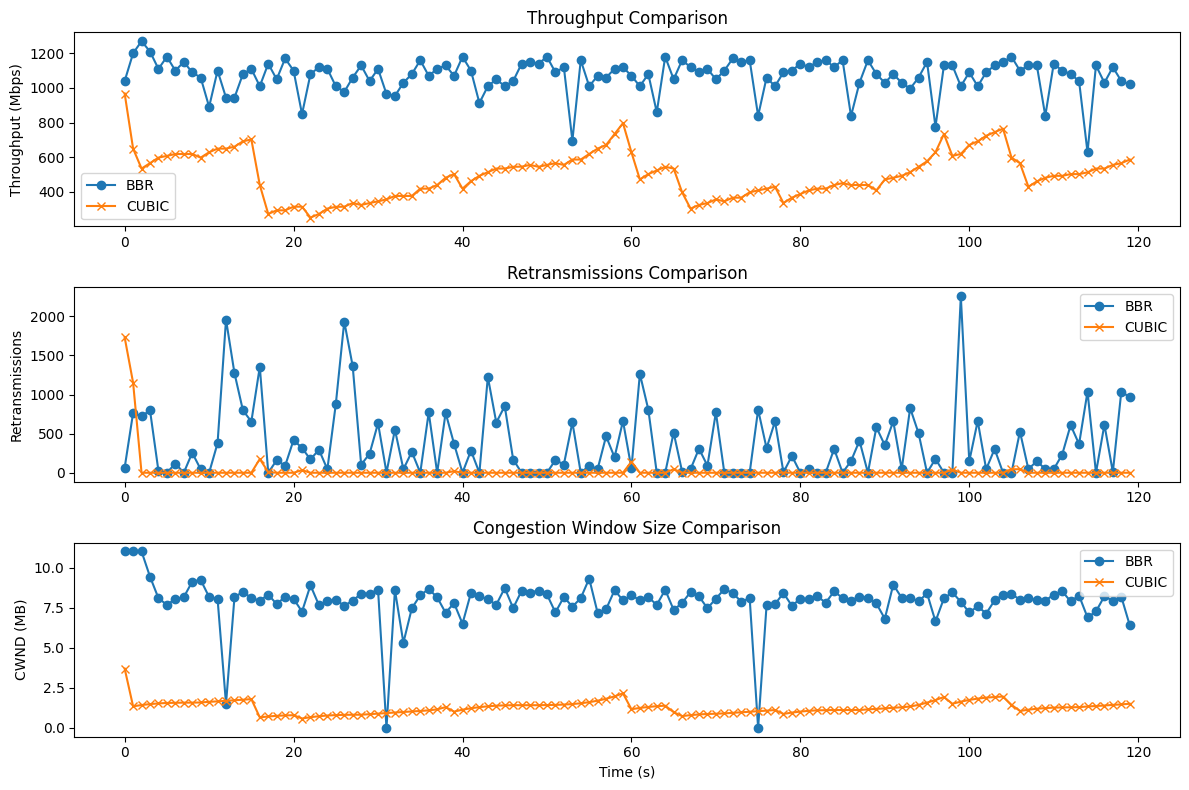

In [99]:
# Convert CWND from KB to MB for better readability
df_loss1_bbr_iperf["CWND (MB)"] = df_loss1_bbr_iperf["CWND (KB)"] / 1024
df_loss1_cubic_iperf["CWND (MB)"] = df_loss1_cubic_iperf["CWND (KB)"] / 1024

# Extract time interval start for plotting
df_loss1_bbr_iperf["Interval Start (s)"] = df_loss1_bbr_iperf["Interval"].str.split("-").str[0].astype(float)
df_loss1_cubic_iperf["Interval Start (s)"] = df_loss1_cubic_iperf["Interval"].str.split("-").str[0].astype(float)

# Plotting
plt.figure(figsize=(12, 8))

# Bitrate Plot
plt.subplot(3, 1, 1)
plt.plot(df_loss1_bbr_iperf["Interval Start (s)"], df_loss1_bbr_iperf["Bitrate (Mbps)"], label="BBR", marker='o')
plt.plot(df_loss1_cubic_iperf["Interval Start (s)"], df_loss1_cubic_iperf["Bitrate (Mbps)"], label="CUBIC", marker='x')
plt.ylabel("Throughput (Mbps)")
plt.title("Throughput Comparison")
plt.legend()

# Retransmissions Plot
plt.subplot(3, 1, 2)
plt.plot(df_loss1_bbr_iperf["Interval Start (s)"], df_loss1_bbr_iperf["Retransmissions"], label="BBR", marker='o')
plt.plot(df_loss1_cubic_iperf["Interval Start (s)"], df_loss1_cubic_iperf["Retransmissions"], label="CUBIC", marker='x')
plt.ylabel("Retransmissions")
plt.title("Retransmissions Comparison")
plt.legend()

# Congestion Window Plot
plt.subplot(3, 1, 3)
plt.plot(df_loss1_bbr_iperf["Interval Start (s)"], df_loss1_bbr_iperf["CWND (MB)"], label="BBR", marker='o')
plt.plot(df_loss1_cubic_iperf["Interval Start (s)"], df_loss1_cubic_iperf["CWND (MB)"], label="CUBIC", marker='x')
plt.xlabel("Time (s)")
plt.ylabel("CWND (MB)")
plt.title("Congestion Window Size Comparison")
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


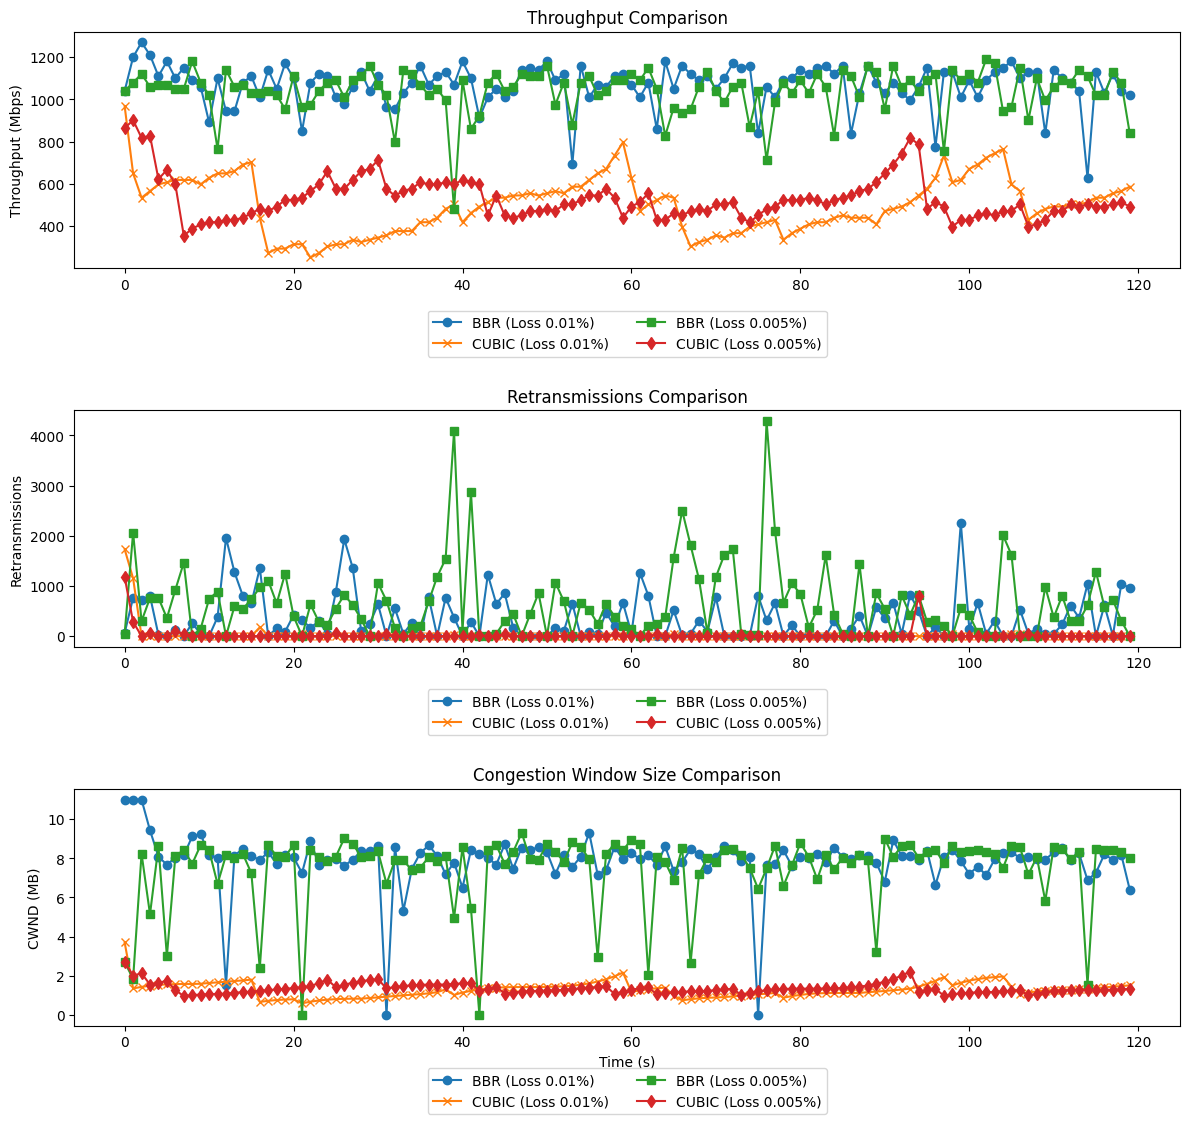

In [104]:
# Plotting
plt.figure(figsize=(12, 12))

# Bitrate Plot
plt.subplot(3, 1, 1)
plt.plot(df_loss1_bbr_iperf["Interval Start (s)"], df_loss1_bbr_iperf["Bitrate (Mbps)"], label="BBR (Loss 0.01%)", marker='o')
plt.plot(df_loss1_cubic_iperf["Interval Start (s)"], df_loss1_cubic_iperf["Bitrate (Mbps)"], label="CUBIC (Loss 0.01%)", marker='x')
plt.plot(df_loss5_bbr_iperf["Interval Start (s)"], df_loss5_bbr_iperf["Bitrate (Mbps)"], label="BBR (Loss 0.005%)", marker='s')
plt.plot(df_loss5_cubic_iperf["Interval Start (s)"], df_loss5_cubic_iperf["Bitrate (Mbps)"], label="CUBIC (Loss 0.005%)", marker='d')
plt.ylabel("Throughput (Mbps)")
plt.title("Throughput Comparison")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)  # Adjusted spacing for legend

# Retransmissions Plot
plt.subplot(3, 1, 2)
plt.plot(df_loss1_bbr_iperf["Interval Start (s)"], df_loss1_bbr_iperf["Retransmissions"], label="BBR (Loss 0.01%)", marker='o')
plt.plot(df_loss1_cubic_iperf["Interval Start (s)"], df_loss1_cubic_iperf["Retransmissions"], label="CUBIC (Loss 0.01%)", marker='x')
plt.plot(df_loss5_bbr_iperf["Interval Start (s)"], df_loss5_bbr_iperf["Retransmissions"], label="BBR (Loss 0.005%)", marker='s')
plt.plot(df_loss5_cubic_iperf["Interval Start (s)"], df_loss5_cubic_iperf["Retransmissions"], label="CUBIC (Loss 0.005%)", marker='d')
plt.ylabel("Retransmissions")
plt.title("Retransmissions Comparison")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)  # Adjusted spacing for legend

# Congestion Window Plot
plt.subplot(3, 1, 3)
plt.plot(df_loss1_bbr_iperf["Interval Start (s)"], df_loss1_bbr_iperf["CWND (MB)"], label="BBR (Loss 0.01%)", marker='o')
plt.plot(df_loss1_cubic_iperf["Interval Start (s)"], df_loss1_cubic_iperf["CWND (MB)"], label="CUBIC (Loss 0.01%)", marker='x')
plt.plot(df_loss5_bbr_iperf["Interval Start (s)"], df_loss5_bbr_iperf["CWND (MB)"], label="BBR (Loss 0.005%)", marker='s')
plt.plot(df_loss5_cubic_iperf["Interval Start (s)"], df_loss5_cubic_iperf["CWND (MB)"], label="CUBIC (Loss 0.005%)", marker='d')
plt.xlabel("Time (s)")
plt.ylabel("CWND (MB)")
plt.title("Congestion Window Size Comparison")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)  # Adjusted spacing for legend

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add extra space at the top
plt.subplots_adjust(hspace=0.6)  # Increase space between subplots
plt.show()




# Fairness

In [116]:
def parse_throughput(file_path):
    # Initialize lists to store parsed data
    intervals, bitrates = [], []
    
    # Regex pattern to match data rows
    pattern = re.compile(r'\[\s*\d+\]\s+([\d\.]+-[\d\.]+)\s+sec\s+[\d\.]+\s+(MBytes|GBytes|KBytes|Bytes)\s+([\d\.]+)\s+(Mbits/sec|bits/sec|Gbits/sec)')
    
    # Open and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                interval = match.group(1)
                bitrate = float(match.group(3))
                
                # Adjust bitrate based on the unit
                if match.group(4) == "Gbits/sec":
                    bitrate *= 1000  # Convert Gbits/sec to Mbits/sec
                elif match.group(4) == "bits/sec":
                    bitrate /= 1_000_000  # Convert bits/sec to Mbits/sec
                
                # Append parsed data to lists
                intervals.append(interval)
                bitrates.append(bitrate)
            elif " 0.00 " in line:  # Catch lines where bitrate is explicitly zero
                interval = re.search(r'\[\s*\d+\]\s+([\d\.]+-[\d\.]+)\s+sec', line)
                if interval:
                    intervals.append(interval.group(1))
                    bitrates.append(0.0)
    
    # Create a DataFrame from the parsed data
    data = {
        "Interval": intervals,
        "Bitrate (Mbps)": bitrates
    }
    df = pd.DataFrame(data)
    
    # Extract the start of each interval as a float for plotting
    df["Time (s)"] = df["Interval"].str.split("-").str[0].astype(float)
    
    return df

df_cubic_fairness = parse_throughput("../data/bulk_traffic/cubic_fairness.txt")
df_bbr_fairness = parse_throughput("../data/bulk_traffic/bbr_fairness.txt")
print(df_cubic_fairness.head())
print(df_bbr_fairness.head())

    Interval  Bitrate (Mbps)  Time (s)
0  0.00-1.00            9.43       0.0
1  1.00-2.00            7.82       1.0
2  2.00-3.00            8.34       2.0
3  3.00-4.00           10.40       3.0
4  4.00-5.00           13.00       4.0
    Interval  Bitrate (Mbps)  Time (s)
0  0.00-1.00            6.68       0.0
1  1.00-2.00            3.41       1.0
2  2.00-3.00            1.70       2.0
3  3.00-4.00            1.70       3.0
4  4.00-5.00            0.00       4.0


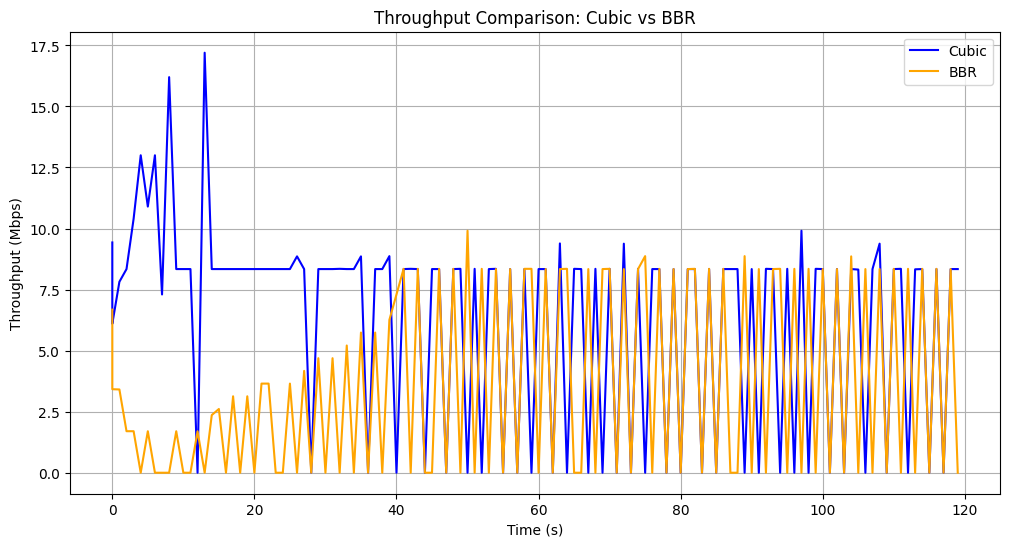

In [117]:
def plot_fairness(df_cubic, df_bbr):
    # Convert interval to start time
    df_cubic['Time (s)'] = df_cubic['Interval'].str.split('-').str[0].astype(float)
    df_bbr['Time (s)'] = df_bbr['Interval'].str.split('-').str[0].astype(float)

    # Sort the data by time
    df_cubic = df_cubic.sort_values(by='Time (s)')
    df_bbr = df_bbr.sort_values(by='Time (s)')

    # Plot the throughput
    plt.figure(figsize=(12, 6))
    plt.plot(df_cubic['Time (s)'], df_cubic['Bitrate (Mbps)'], label='Cubic', color='blue')
    plt.plot(df_bbr['Time (s)'], df_bbr['Bitrate (Mbps)'], label='BBR', color='orange')
    
    # Add labels, title, and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Throughput (Mbps)')
    plt.title('Throughput Comparison: Cubic vs BBR')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

plot_fairness(df_cubic_fairness, df_bbr_fairness)